In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 27 11:11:44 2023

@author: bas
copied from: https://github.com/xpsi-group/xpsi/blob/main/examples/examples_fast/Synthetic_data.ipynb
"""



import os
import numpy as np
import math


from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import xpsi
from xpsi import Parameter, HotRegions
from scipy.interpolate import Akima1DInterpolator
from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

import sys
sys.path.append('../')
from custom_tools import CustomInstrumentJ1808, CustomHotRegion, CustomHotRegion_Accreting, CustomHotRegion_Accreting_te_const, CustomPhotosphere_BB, CustomPhotosphere_N4, CustomPhotosphere_N5, CustomPhotosphere_A5, CustomPhotosphere_A4, CustomSignal, CustomPrior, CustomPrior_NoSecondary, plot_2D_pulse, CustomBackground, CustomBackground_BB_PL, SynthesiseData

################################## SETTINGS ###################################

second = False
te_index = 0

try: #try to get parameters from shell input
    os.environ.get('atmosphere_type')    
    atmosphere_type = os.environ['atmosphere_type']
    os.environ.get('n_params')
    n_params = os.environ['n_params']
except:
    atmosphere_type = "A"
    n_params = "5"

if atmosphere_type == 'N':
    exposure_time=50000. #Reproducing NSX atmosphere data would require exposure time of 984307.6661
elif atmosphere_type == 'A':
    exposure_time=1.36374e5 # 1.36374e5 is the same as Mason 2019      #Reproducing Mason's J1808 data with no background = 2350000.
else:
    print('Problem with exposure time!')
print("atmosphere_type:", atmosphere_type)
print("n_params:", n_params)

################################## INSTRUMENT #################################
channel_low = 20
channel_hi = 300 #600 #500 #300 commented numbers work
max_input = 1400 #2000 #1800 #1400

NICER = CustomInstrumentJ1808.from_response_files(ARF = '../model_data/J1808/ni2584010103mpu7_arf_aeff.txt',
                                                  RMF = '../model_data/J1808/ni2584010103mpu7_rmf_matrix.txt',
                                                  channel_edges = '../model_data/J1808/ni2584010103mpu7_rmf_energymap.txt',
                                                  channel_low=channel_low,
                                                  channel_hi=channel_hi,
                                                  max_input=max_input)


/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
atmosphere_type: A
n_params: 5
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


In [2]:
############################### SPACETIME #####################################

bounds = dict(distance = (0.1, 10.0),                       # (Earth) distance
                mass = (1.0, 3.0),                          # mass
                radius = (3.0 * gravradius(1.0), 16.0),     # equatorial radius
                cos_inclination = (0.0, 1.0))               # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=401.0))# Fixing the spin

############################### SINGLE HOTREGION ##############################

num_leaves = 128
sqrt_num_cells = 128
num_rays = 512

kwargs = {'symmetry': 'azimuthal_invariance', #call general integrator instead of for azimuthal invariance
          'interpolator': 'split',
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}
values = {}
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1))
if atmosphere_type=='A':
    bounds['super_tbb'] = (0.001, 0.003)
    bounds['super_tau'] = (0.5, 3.5)
    if n_params=='5':
        bounds['super_te'] = (40., 200.)
        primary = CustomHotRegion_Accreting(bounds, values, **kwargs)
    elif n_params=='4':    
        primary = CustomHotRegion_Accreting_te_const(bounds, values, **kwargs)
elif atmosphere_type=='N':
    bounds['super_temperature'] = (5.1, 6.8)
    if n_params=='4':
        primary = xpsi.HotRegion(bounds, values, **kwargs)
    elif n_params=='5':
        kwargs['modulated'] = True
        bounds['super_modulator'] = (-0.3, 0.3)
        primary = CustomHotRegion(bounds, values, **kwargs)
elif atmosphere_type=='B':
    bounds['super_temperature'] = (5.1, 6.8)
    primary = CustomHotRegion(bounds, values, **kwargs)

hot = HotRegions((primary,))
    
################################ ATMOSPHERE ################################### 
      
if atmosphere_type=='A':
    if n_params== "5":
        photosphere = CustomPhotosphere_A5(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))

    elif n_params== "4":
        photosphere = CustomPhotosphere_A4(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
        photosphere.te_index = te_index
    # LOCAL
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
    # SNELLIUS
    #photosphere.hot_atmosphere = '/home/dorsman/xpsi-bas-fork/AMXPs/model_data/Bobrikova_compton_slab.npz'

elif atmosphere_type=='N':
    if n_params == "4":   
        photosphere = CustomPhotosphere_N4(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
        photosphere.hot_atmosphere = '/home/bdorsma/xpsi-bas/AMXPs/model_data/nsx_H_v171019.npz'  
	# photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019.npz'
    
    elif n_params== "5":
        photosphere = CustomPhotosphere_N5(hot = hot, elsewhere = None,
                                        values=dict(mode_frequency = spacetime['frequency']))
        # photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_5D_no_effect.npz'
        photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/model_data/H-atmosphere_Spectra_fully_ionized/NSX_H-atmosphere_Spectra/nsx_H_v171019_modulated_0dot5_to_2.npz'
        # photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/Bobrikova_compton_slab.npz'

elif atmosphere_type=="B":
    photosphere = CustomPhotosphere_BB(hot = hot, elsewhere = None, 
                                       values=dict(mode_frequency = spacetime['frequency']))


else:
    print("no atmosphere_type provided!")
    
################################### STAR ######################################

star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

#################################### PRIOR ####################################

prior = CustomPrior_NoSecondary()

############################### BACKGROUND ####################################

background = CustomBackground_BB_PL(bounds=(None, None))


Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.
Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [ra

In [3]:

###################### SYNTHESISE DATA #################################



#_data = SynthesiseData(np.arange(10,301), np.linspace(0.0, 1.0, 33), 0, 290 )
phases_space = np.linspace(0.0, 1.0, 33)
#phases_space = np.linspace(0.015625,1.015625,33)[:-1] #J1808 2019

_data = SynthesiseData(np.arange(channel_low,channel_hi), phases_space, 0, channel_hi-channel_low-1) #Apparently some hardcoded stuff for NICER


from xpsi.tools.synthesise import synthesise_exposure_no_scaling as _synthesise

def synthesise(self,
               exposure_time,
               name='no_pulse',
               directory='./',
               **kwargs):
    
        """ Synthesise data set.

        """
        self._expected_counts, self.synthetic_data = _synthesise(exposure_time,
                                                             self._data.phases,
                                                             self._signals,
                                                             self._phases,
                                                             self._shifts,
                                                             self._background.registered_background,
                                                             gsl_seed=42)
        

CustomSignal.synthesise = synthesise

################################## SIGNAL ###################################
signal = CustomSignal(data = _data,
                        instrument = NICER, #Instrument
                        background = background,
                        interstellar = None,
                        cache = True,
                        prefix='Instrument')


################################# LIKELIHOOD ###############################
likelihood = xpsi.Likelihood(star = star, signals = signal,
                             num_energies=128, #384
                             threads=8, #1
                             externally_updated=False,
                             prior = prior)                             


for h in hot.objects:
    h.set_phases(num_leaves)


print("Prossecco ...")

# SAX J1808-like 
mass = 1.4
radius = 12.
distance = 3.5
inclination = 60
cos_inclination = math.cos(inclination*math.pi/180)
phase_shift = 0
super_colatitude = 20*math.pi/180
super_radius = 0.001 #15.5*math.pi/180 #0.001 makes hotregion disappear

if atmosphere_type=='A':
    if n_params=='5':
        # Compton slab model parameters
        tbb=0.0015 #0.001 -0.003 Tbb(data) = Tbb(keV)/511keV, 1 keV = 0.002 data
        te=100. #40-200 corresponds to 20-100 keV (Te(data) = Te(keV)*1000/511keV), 50 keV = 100 data
        tau=1. #0.5 - 3.5 tau = ln(Fin/Fout)
        

        p = [mass, #1.4, #grav mass
              radius,#12.5, #coordinate equatorial radius
              distance, # earth distance kpc
              cos_inclination, #cosine of earth inclination
              phase_shift, #phase of hotregion
              super_colatitude, #colatitude of centre of superseding region
              super_radius,  #angular radius superceding region
              tbb,
              te,
              tau
              ]


background_BB_temperature = 6.8 #7.
p.append(background_BB_temperature)

BB_radius = 800 # km

background_BB_normalisation = (BB_radius/distance*10)**2  # (km / 10 kpc)^2
print(background_BB_normalisation)
p.append(background_BB_normalisation)

background_PL_index = 2.
p.append(background_PL_index)

background_PL_normalisation = 3.32e-2
p.append(background_PL_normalisation)

print("printing Parameters of the star:")
print(star.params)

Instrument_kwargs = dict(exposure_time=exposure_time,              
                         name='J1808',
                         directory='./data/')

likelihood.synthesise(p, force=True, Instrument=Instrument_kwargs) 

print("Done !")

print('signals:', np.sum(signal.signals))
print('expected counts:', np.sum(signal.expected_counts))

########## DATA PLOT ###############

synthetic_data_2D=signal.synthetic_data  # np.loadtxt('./data/J1808_realisation.dat'.format(atmosphere_type, n_params))
synthetic_data = np.sum(synthetic_data_2D, axis=1)



Setting channels for event data...
Channels set.
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.
Prossecco ...
5224489.795918368
printing Parameters of the star:
[Gravitational mass [solar masses], Coordinate equatorial radius [km], Earth distance [kpc], Cosine of Earth inclination to rotation axis, The phase of the hot region, a periodic parameter [cycles], The colatitude of the centre of the superseding region [radians], The angular radius of the (circular) superseding region [radians], tbb, te, tau]
Done !
signals: 0.029543592363987476
expected counts: 83135393.50964066


Text(0.5, 1.0, 'atm=A params=5 te=5.11e+01 [keV], tbb=7.67e-01 [keV], tau=1.00e+00 [-]')

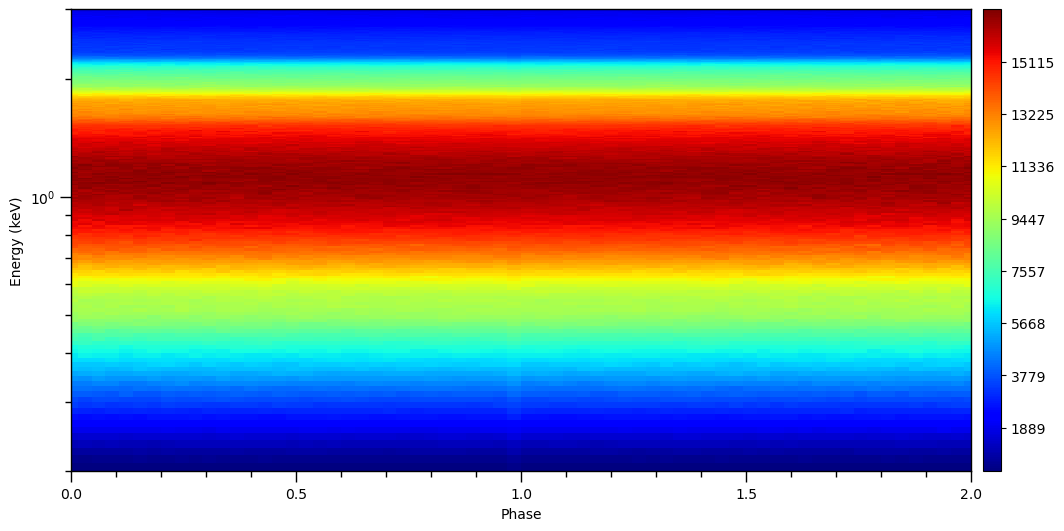

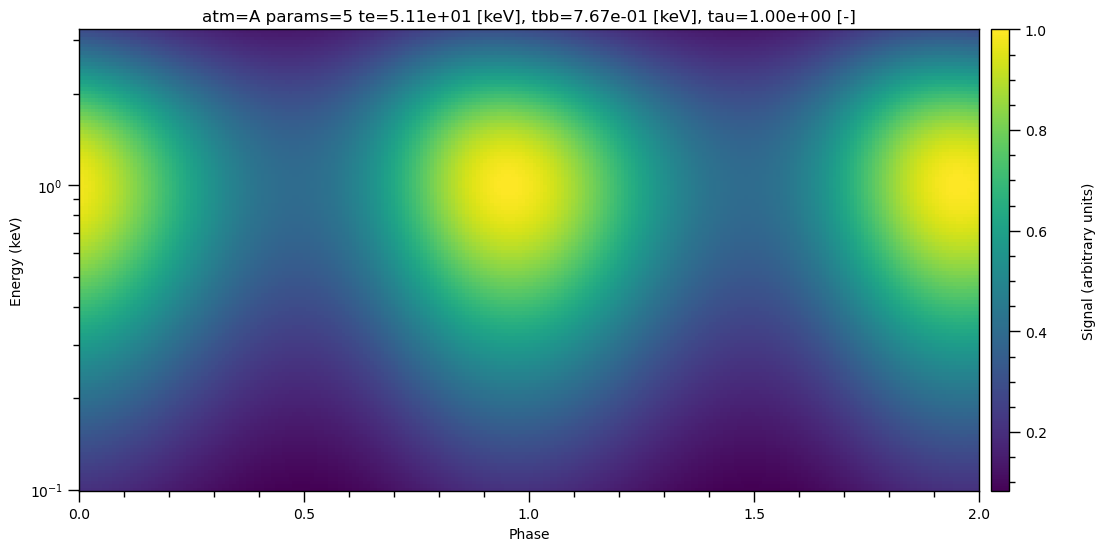

In [4]:
# fig,ax=plt.subplots(1,1,figsize=(10,5))



from custom_tools import get_values_from_edges
NICER.channel_values = get_values_from_edges(NICER.channel_edges)


ax = plot_2D_pulse((synthetic_data_2D,),
              x=phases_space,
              shift=signal.shifts,
              y=NICER.channel_values,  # NICER.channel_edges[:-1]
              ylabel=r'Energy (keV)',
              cm=cm.jet,
              num_rotations=2.0,
              normalize=False)


################ SIGNAL PLOT ###################################

if second:
    ax = plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
                  x=signal.phases[0],
                  shift=signal.shifts,
                  y=signal.energies,
                  ylabel=r'Energy (keV)')
if not second:
    # print('photosphere.signal[0][0]', photosphere.signal[0][0])
    ax = plot_2D_pulse((photosphere.signal[0][0],),
                  x=signal.phases[0],
                  shift=signal.shifts,
                  y=signal.energies,
                  ylabel=r'Energy (keV)',
                  num_rotations=2.0)


ax.set_title('atm={} params={} te={:.2e} [keV], tbb={:.2e} [keV], tau={:.2e} [-]'.format(atmosphere_type, n_params, te*0.511, tbb*511, tau), loc='center') #unit conversion te and tbb is different due to a cluster leftover according to Anna B.

In [5]:
J1808_2019_nonpulsed_2D = np.loadtxt('J1808_2019_nonpulsed.txt')[:,:32]
J1808_2019_nonpulsed = np.sum(J1808_2019_nonpulsed_2D, axis=1)

J1808_channel_values = np.linspace(0.32, 10.48, 255)

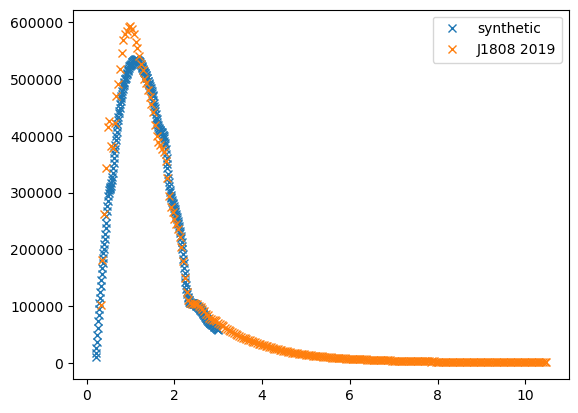

In [6]:
fig, ax = plt.subplots()

ax.plot(NICER.channel_values, synthetic_data, 'x', label='synthetic') 
ax.plot(J1808_channel_values, J1808_2019_nonpulsed, 'x', label='J1808 2019')
ax.legend()

# interpolate synthetic data such that it has same data points as J1808 2019

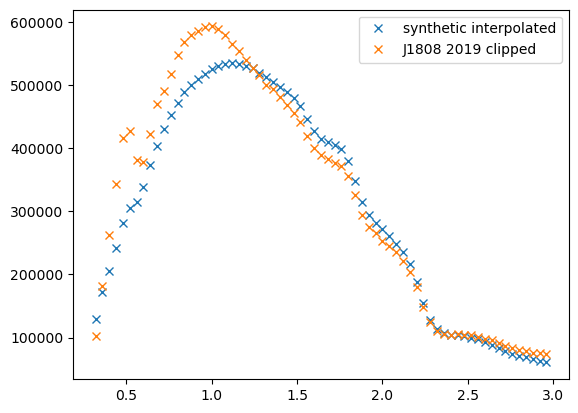

In [7]:
# maximum of synthetic data
sd_max = NICER.channel_values.max()

#cut-off J1808 data beyond sd_max
J1808_channel_values_clipped = J1808_channel_values[J1808_channel_values<sd_max]
J1808_2019_nonpulsed_clipped = J1808_2019_nonpulsed[J1808_channel_values<sd_max]

# interpolate synthetic data to match clipped J1808 data
synthetic_data_interpolated_channels = np.interp(J1808_channel_values_clipped, NICER.channel_values, synthetic_data)

fig, ax = plt.subplots()

ax.plot(J1808_channel_values_clipped, synthetic_data_interpolated_channels, 'x', label='synthetic interpolated') 
ax.plot(J1808_channel_values_clipped, J1808_2019_nonpulsed_clipped, 'x', label='J1808 2019 clipped')
ax.legend()

In [8]:
chi_squared = np.sum((synthetic_data_interpolated_channels - J1808_2019_nonpulsed_clipped)**2)
print(chi_squared)

119173071692.98976


In [9]:
def least_squares(params):
    print(params)
    
    p_opt = [mass, #1.4, #grav mass
              radius,#12.5, #coordinate equatorial radius
              distance, # earth distance kpc
              cos_inclination, #cosine of earth inclination
              phase_shift, #phase of hotregion
              super_colatitude, #colatitude of centre of superseding region
              super_radius,  #angular radius superceding region
              tbb,
              te,
              tau
              ]

    p_opt.append(params[0])

    background_BB_normalisation = params[1]
    p_opt.append(background_BB_normalisation)
    
    background_PL_index = params[2] #2.
    p_opt.append(background_PL_index)

    background_PL_normalisation = params[3] #3.32e-2
    p_opt.append(background_PL_normalisation)

    likelihood.synthesise(p_opt, force=True, Instrument=Instrument_kwargs) 

    synthetic_data = np.sum(signal.synthetic_data, axis=1)
    
    # maximum of synthetic data
    sd_max = NICER.channel_values.max()

    #cut-off J1808 data beyond sd_max
    J1808_channel_values_clipped = J1808_channel_values[J1808_channel_values<sd_max]
    J1808_2019_nonpulsed_clipped = J1808_2019_nonpulsed[J1808_channel_values<sd_max]

    # interpolate synthetic data to match clipped J1808 data
    synthetic_data_interpolated_channels = np.interp(J1808_channel_values_clipped, NICER.channel_values, synthetic_data)
    
    chi_squared = np.sum((synthetic_data_interpolated_channels - J1808_2019_nonpulsed_clipped)**2)
    print(chi_squared)
    return chi_squared

params = [6.8, 800, 2, 3.32e-2]

least_squares(params)

[6.8, 800, 2, 0.0332]
9137652801943.016


9137652801943.016

In [10]:
import scipy.optimize as optimize

bounds=[(3,10),(1e1,1e8), (1., 4.), (1e-4, 1e4)]
#initial_guess = [6.8, 800, 2, 3.32e-2]
initial_guess = [6.8, 5224489, 2, 3.32]

result = optimize.minimize(least_squares, initial_guess, bounds=bounds, method='nelder-mead')
if result.success:
    T_opt, r_BB_opt, G_PL_opt, k_PL_opt = result.x
    print(f'T_opt: {T_opt}')
    print(f'r_BB_opt: {r_BB_opt}')
    print(f'G_PL_opt: {G_PL_opt}')
    print(f'k_PL_opt: {k_PL_opt}')
else:
    raise ValueError(result.message)

[6.800000e+00 5.224489e+06 2.000000e+00 3.320000e+00]
111976843569.01501
[7.140000e+00 5.224489e+06 2.000000e+00 3.320000e+00]
185061305364359.97
[6.80000000e+00 5.48571345e+06 2.00000000e+00 3.32000000e+00]
96510318933.08862
[6.800000e+00 5.224489e+06 2.100000e+00 3.320000e+00]
111972641800.05447
[6.800000e+00 5.224489e+06 2.000000e+00 3.486000e+00]
111521594322.27585
[6.46000000e+00 5.35510122e+06 2.05000000e+00 3.40300000e+00]
7667016355197.97
[6.63000000e+00 5.32244817e+06 2.03750000e+00 3.38225000e+00]
4266705549548.0444
[6.97000000e+00 5.25714206e+06 2.01250000e+00 3.34075000e+00]
21272645993070.055
[6.71500000e+00 5.30612164e+06 2.03125000e+00 3.37187500e+00]
1707764942453.5276
[6.88500000e+00 5.27346858e+06 2.01875000e+00 3.35112500e+00]
3558667130358.963
[6.75750000e+00 5.29795838e+06 2.02812500e+00 3.36668750e+00]
614771791076.404
[6.84250000e+00 5.28163185e+06 2.02187500e+00 3.35631250e+00]
779570215004.6792
[6.77875000e+00 5.29387674e+06 2.02656250e+00 3.36409375e+00]
25539

38424861926.372
[6.74969524e+00 7.46022231e+06 1.74708830e+00 3.32397469e+00]
38408769310.813385
[6.74968995e+00 7.46088947e+06 1.74727701e+00 3.32491051e+00]
38140181572.77063
[6.74972226e+00 7.45925882e+06 1.74738950e+00 3.32363680e+00]
38312459786.88401
[6.74969629e+00 7.46021331e+06 1.74748502e+00 3.32321165e+00]
38450833460.089615
[6.74971742e+00 7.45952598e+06 1.74743822e+00 3.32487370e+00]
38424976854.38275
[6.74971214e+00 7.45969781e+06 1.74744992e+00 3.32445818e+00]
38367413921.58398
[6.74972691e+00 7.45925473e+06 1.74801575e+00 3.32435240e+00]
38262567416.62123
[6.74971740e+00 7.45955769e+06 1.74793704e+00 3.32381601e+00]
38339918906.40779
[6.74971609e+00 7.45959272e+06 1.74781526e+00 3.32397655e+00]
38366887852.750015
[6.74970496e+00 7.45999873e+06 1.74768434e+00 3.32427960e+00]
38369072104.726364
[6.74972344e+00 7.45918136e+06 1.74805371e+00 3.32400054e+00]
38162873339.73586
[6.74972111e+00 7.45918340e+06 1.74774058e+00 3.32364274e+00]
38262312476.89931
[6.74971605e+00 7.45

37913130900.53059
[6.74972112e+00 7.45906657e+06 1.74802983e+00 3.32358215e+00]
37925445699.284355
[6.74972112e+00 7.45906654e+06 1.74802955e+00 3.32358201e+00]
37913130900.53059
[6.74972112e+00 7.45906656e+06 1.74802973e+00 3.32358210e+00]
37913130900.53059
[6.74972112e+00 7.45906655e+06 1.74802959e+00 3.32358204e+00]
37913130900.53059
[6.74972112e+00 7.45906661e+06 1.74802960e+00 3.32358206e+00]
37913130900.53059
[6.74972112e+00 7.45906649e+06 1.74802973e+00 3.32358219e+00]
37913130900.53059
[6.74972112e+00 7.45906654e+06 1.74802982e+00 3.32358210e+00]
37913130900.53059
[6.74972112e+00 7.45906654e+06 1.74802971e+00 3.32358212e+00]
37913130900.53059
[6.74972112e+00 7.45906655e+06 1.74802980e+00 3.32358217e+00]
37913130900.53059
[6.74972112e+00 7.45906654e+06 1.74802973e+00 3.32358213e+00]
37913130900.53059
[6.74972112e+00 7.45906657e+06 1.74802973e+00 3.32358215e+00]
37913130900.53059
[6.74972112e+00 7.45906651e+06 1.74802980e+00 3.32358221e+00]
37913130900.53059
[6.74972112e+00 7.459

In [14]:
def print_optimized(params):
    
    p_opt = [mass, #1.4, #grav mass
              radius,#12.5, #coordinate equatorial radius
              distance, # earth distance kpc
              cos_inclination, #cosine of earth inclination
              phase_shift, #phase of hotregion
              super_colatitude, #colatitude of centre of superseding region
              super_radius,  #angular radius superceding region
              tbb,
              te,
              tau
              ]

    p_opt.append(params[0])

    background_BB_normalisation = params[1]
    p_opt.append(background_BB_normalisation)

    background_PL_index = params[2] #2.
    p_opt.append(background_PL_index)

    background_PL_normalisation = params[3] #3.32e-2
    p_opt.append(background_PL_normalisation)
    
    likelihood.synthesise(p_opt, force=True, Instrument=Instrument_kwargs) 

    synthetic_data = np.sum(signal.synthetic_data, axis=1)
    
    # maximum of synthetic data
    sd_max = NICER.channel_values.max()

    #cut-off J1808 data beyond sd_max
    J1808_channel_values_clipped = J1808_channel_values[J1808_channel_values<sd_max]
    J1808_2019_nonpulsed_clipped = J1808_2019_nonpulsed[J1808_channel_values<sd_max]

    # interpolate synthetic data to match clipped J1808 data
    synthetic_data_interpolated_channels = np.interp(J1808_channel_values_clipped, NICER.channel_values, synthetic_data)
    
    fig, ax = plt.subplots()

    ax.plot(J1808_channel_values_clipped, synthetic_data_interpolated_channels, 'x', label='synthetic interpolated') 
    ax.plot(J1808_channel_values_clipped, J1808_2019_nonpulsed_clipped, 'x', label='J1808 2019 clipped')
    ax.set_xlabel('E (keV)')
    ax.set_ylabel('summed counts')
    ax.legend()

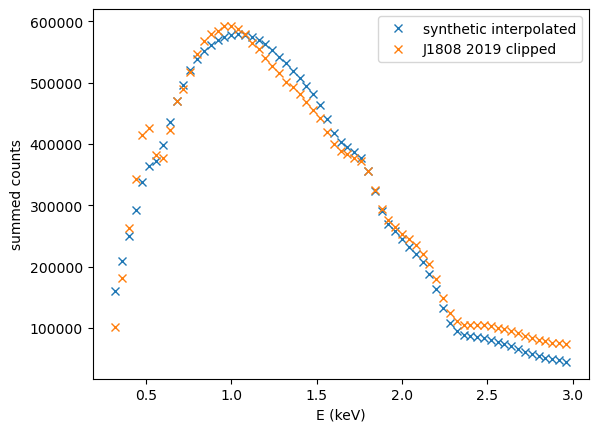

In [15]:
T_opt= 6.749721118220627
r_BB_opt= 7459066.531462396
G_PL_opt= 1.7480298668392127
k_PL_opt= 3.323582232066137
params_opt = [T_opt, r_BB_opt, G_PL_opt, k_PL_opt]
print_optimized(params_opt)